In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.colors
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from darts import TimeSeries
from darts.metrics import mape
from darts.dataprocessing.transformers import Scaler
from IPython.display import display
pio.renderers.default = "png"
pio.templates.default = "plotly_dark"

colors = plotly.colors.qualitative.Plotly

from src.preprocess import create_simple_features, Preprocessor, baseline_model_data
from src.utils import (
    plot_feature_target_correlation, 
    plot_price_distribution,
    plot_price_availability,
    plot_feature_target_relation
)
from src.models import fit_regression_model, fit_baseline_model, ModelLags

file_path = "../data/senior_ds_test.csv"
data = pd.read_csv(file_path)

print("Data shape:", data.shape)

Data shape: (521, 15)


/Users/vaibhavvaidya/.pyenv/versions/3.11.8/envs/merqato/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [3]:
print("\nMissing values per column:")
display(data.isnull().sum())

print("\nStatistical summary:")
display(data.describe())

price_available = data['price'].notna().sum()
price_missing = data['price'].isna().sum()
print(f"\nPrice data available: {price_available} entries ({price_available/len(data)*100:.1f}%)")
print(f"Price data missing: {price_missing} entries ({price_missing/len(data)*100:.1f}%)")


Missing values per column:


Unnamed: 0          0
year                0
week                0
windspeed           0
temp                0
cloudcover          0
precip              0
solarradiation      0
start_date        242
end_date          242
category          242
unit              242
price_min         242
price_max         242
price             242
dtype: int64


Statistical summary:


,Unnamed: 0,year,week,windspeed,temp,cloudcover,precip,solarradiation,price_min,price_max,price
count,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,279.000000,279.000000,279.000000
mean,261.000000,2018.007678,26.600768,18.678273,19.304524,37.131187,0.860611,204.643927,1.898351,2.339104,2.118728
std,150.544013,2.911505,15.097692,4.311509,6.263942,14.614186,2.520322,80.698016,1.154909,1.201890,1.160889
min,1.000000,2013.000000,1.000000,7.271429,6.428571,2.985714,0.000000,57.085714,0.490000,0.490000,0.490000
25%,131.000000,2016.000000,14.000000,16.028571,13.557143,26.500000,0.000000,128.900000,0.980000,1.420000,1.160000
50%,261.000000,2018.000000,27.000000,18.885714,18.900000,37.385714,0.022429,198.514286,1.520000,2.020000,1.760000
75%,391.000000,2020.000000,40.000000,20.942857,24.742857,47.242857,0.572714,278.514286,2.480000,3.025000,2.805000
max,521.000000,2023.000000,53.000000,36.728571,32.100000,92.700000,33.919857,358.571429,5.520000,6.000000,5.760000



Price data available: 279 entries (53.6%)
Price data missing: 242 entries (46.4%)


### Feature understanding

#### Check the target distribution and whether the prices columns (min, max and target) the same

In [4]:
# check if the columns price_min, price_max and price columns are the same
price_min_max_same = (data['price_min'] == data['price_max']).all()
price_min_price_same = (data['price_min'] == data['price']).all()
print(f"\nPrice_min and price_max are the same: {price_min_max_same}")
print(f"Price_min and price are the same: {price_min_price_same}")



Price_min and price_max are the same: False
Price_min and price are the same: False


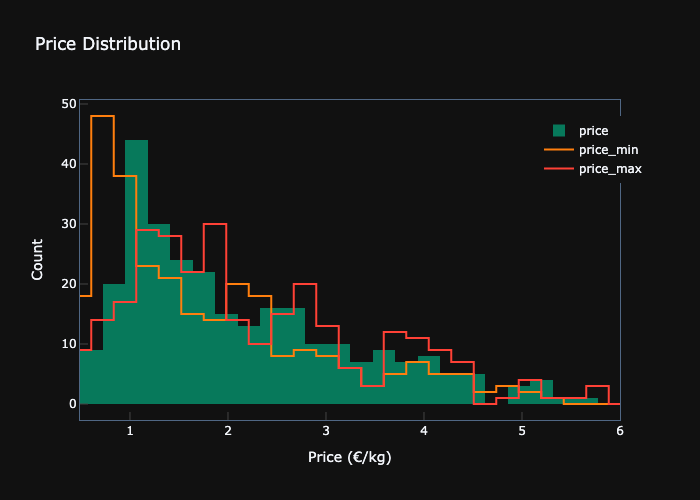

In [5]:
plot_price_distribution(data)

In [6]:
CLIMATE_FEATURES = ["windspeed", "temp", "precip", "cloudcover", "solarradiation"]

### Check missing data and seasonality

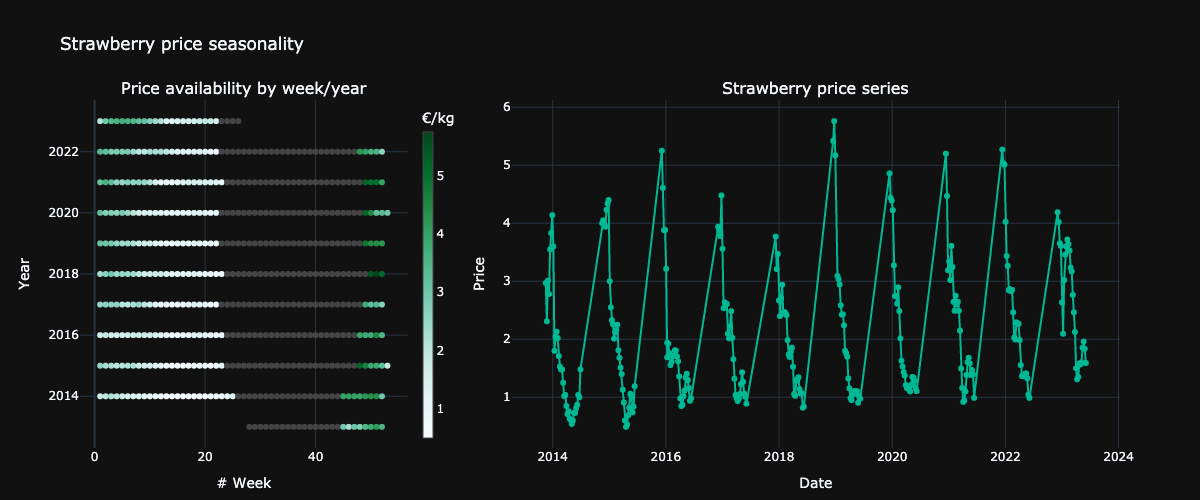

In [7]:
plot_price_availability(data)

### Visualise climate features YoY

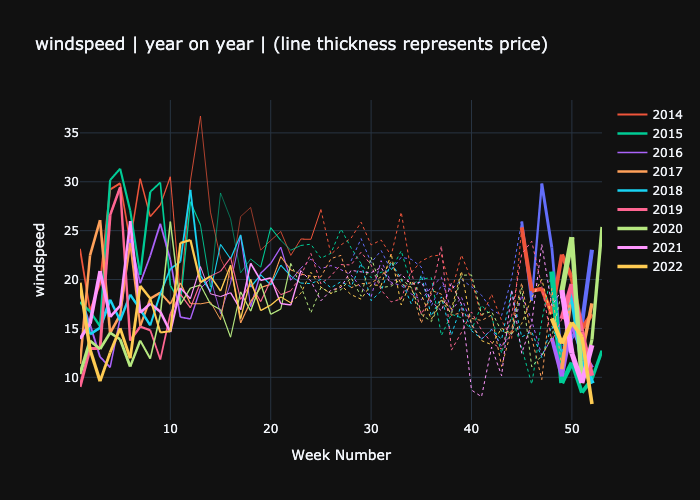

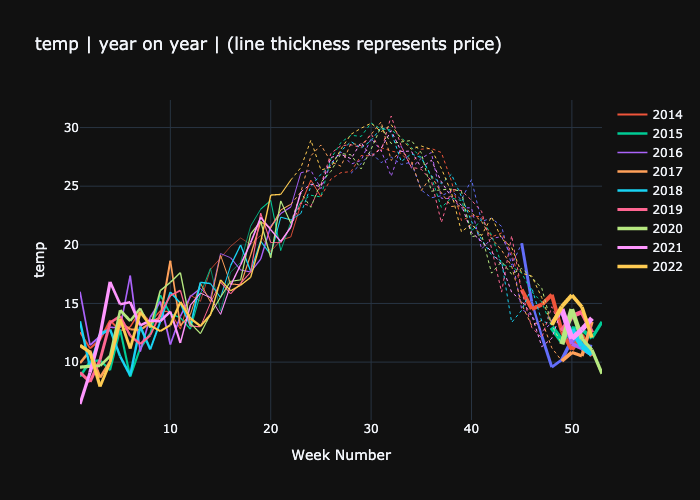

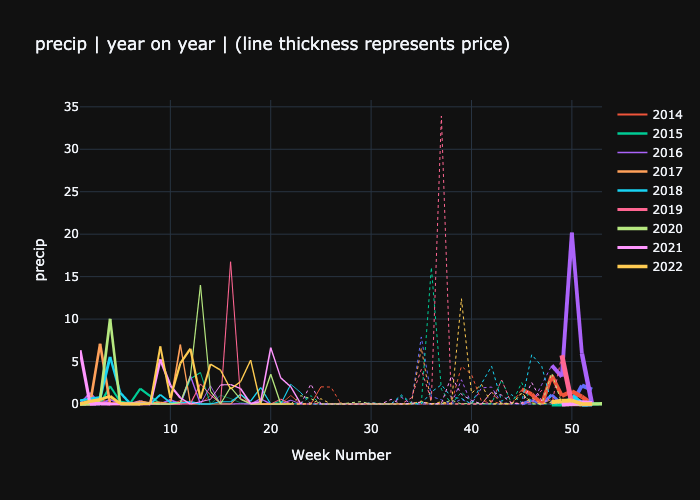

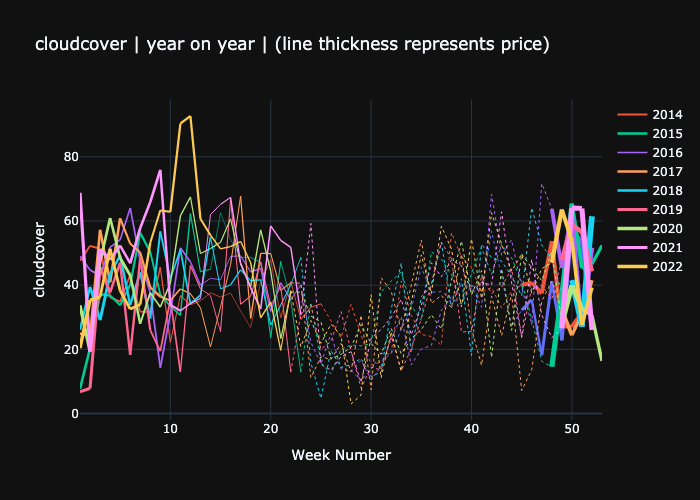

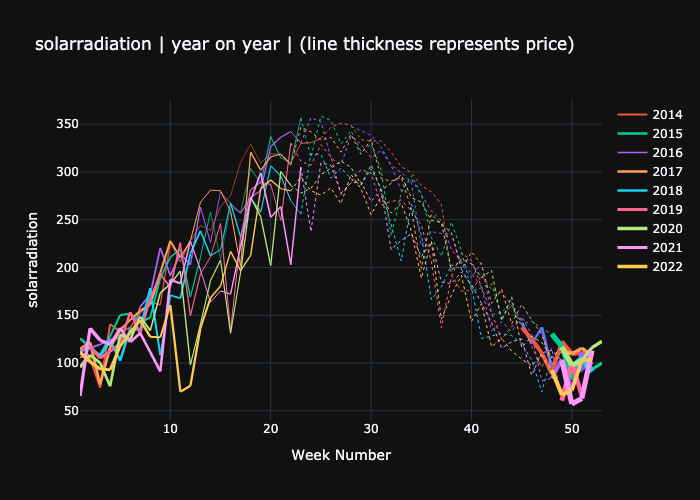

In [8]:
plot_feature_target_relation(data)

### Feature engineering
1. Modelling simple lags, aggregations of climate's effect strawberry production (which should impact price directly)
2. Some quick internet research suggests: the rough time for a strawberry flower to mature into a harvestable berry is roughly 4-6 weeks (https://www.epicgardening.com/strawberry-growth-stages/).
3. Assuming we have growers who can produce berries through out the year, we can model the price based on aggregated climate features like temp/radiation 4 and 6 weeks prior to current week so we can forecast prices 1/2 weeks ahead

In [9]:
df_features = create_simple_features(data, price_lag=True, weather_lag=True, aggregate_features=True)
LAG_AGGREGATION_FEATURES = [col for col in df_features.columns if col not in data.columns]
print("Added features:", LAG_AGGREGATION_FEATURES)
df_features.head(15)

Added features: ['price_lag2', 'price_lag4', 'temp_lag2', 'temp_lag4', 'solarradiation_lag2', 'solarradiation_lag4', 'precip_lag2', 'precip_lag4', 'windspeed_lag2', 'windspeed_lag4', 'temp_sum_4w', 'solar_sum_4w', 'precip_sum_4w', 'week_sin', 'week_cos']


,Unnamed: 0,year,week,windspeed,temp,cloudcover,precip,solarradiation,start_date,end_date,...,solarradiation_lag4,precip_lag2,precip_lag4,windspeed_lag2,windspeed_lag4,temp_sum_4w,solar_sum_4w,precip_sum_4w,week_sin,week_cos
0,1,2013,28,21.900000,26.100000,13.500000,0.013000,347.200000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.239316,-9.709418e-01
1,2,2013,29,24.185714,26.914286,10.242857,0.000000,343.414286,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.354605,-9.350162e-01
2,3,2013,30,21.728571,27.871429,13.785714,0.000000,338.100000,NaN,NaN,...,NaN,0.013000,NaN,21.900000,NaN,NaN,NaN,NaN,-0.464723,-8.854560e-01
3,4,2013,31,22.971429,27.014286,18.900000,0.000000,325.757143,NaN,NaN,...,NaN,0.000000,NaN,24.185714,NaN,107.900000,1354.471429,0.013000,-0.568065,-8.229839e-01
4,5,2013,32,20.942857,27.485714,18.457143,0.032714,307.000000,NaN,NaN,...,347.200000,0.000000,0.013000,21.728571,21.900000,109.285714,1314.271429,0.032714,-0.663123,-7.485107e-01
5,6,2013,33,22.285714,26.857143,26.300000,0.000000,299.614286,NaN,NaN,...,343.414286,0.000000,0.000000,22.971429,24.185714,109.228571,1270.471429,0.032714,-0.748511,-6.631227e-01
6,7,2013,34,22.071429,27.042857,32.557143,0.000000,289.685714,NaN,NaN,...,338.100000,0.032714,0.000000,20.942857,21.728571,108.400000,1222.057143,0.032714,-0.822984,-5.680647e-01
7,8,2013,35,21.285714,24.671429,45.614286,7.896571,222.628571,NaN,NaN,...,325.757143,0.000000,0.000000,22.285714,22.971429,106.057143,1118.928571,7.929286,-0.885456,-4.647232e-01
8,9,2013,36,17.328571,24.014286,37.742857,0.884857,237.614286,NaN,NaN,...,307.000000,0.000000,0.032714,22.071429,20.942857,102.585714,1049.542857,8.781429,-0.935016,-3.546049e-01
9,10,2013,37,19.414286,24.185714,37.985714,0.497143,235.485714,NaN,NaN,...,299.614286,7.896571,0.000000,21.285714,22.285714,99.914286,985.414286,9.278571,-0.970942,-2.393157e-01


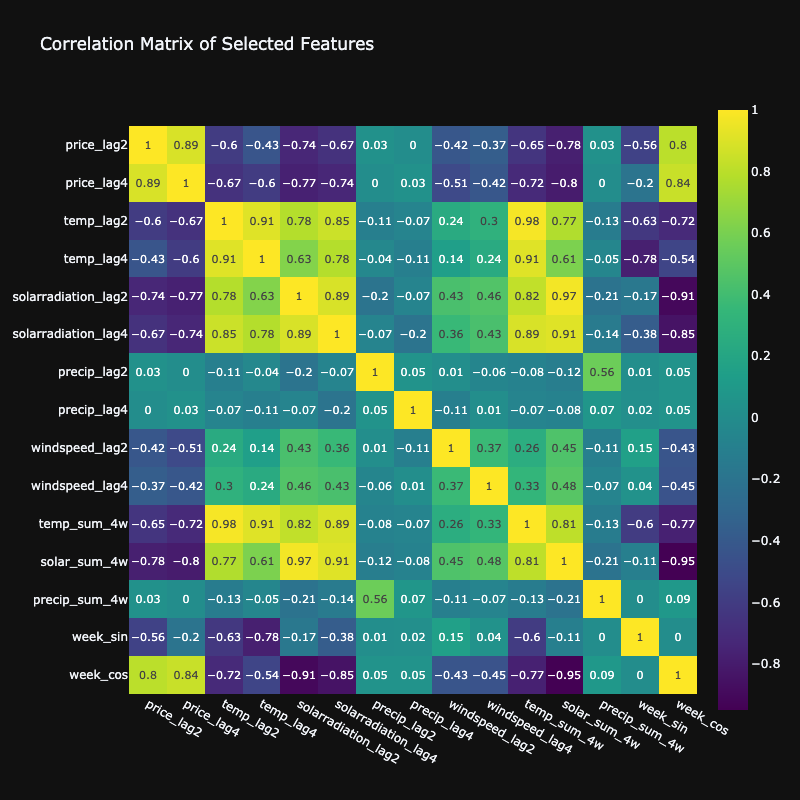

In [10]:
corr_matrix = df_features[LAG_AGGREGATION_FEATURES].corr().round(2)

fig = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale="Viridis",
    title="Correlation Matrix of Selected Features"
)
fig.update_layout(width=800, height=800)
fig.show()

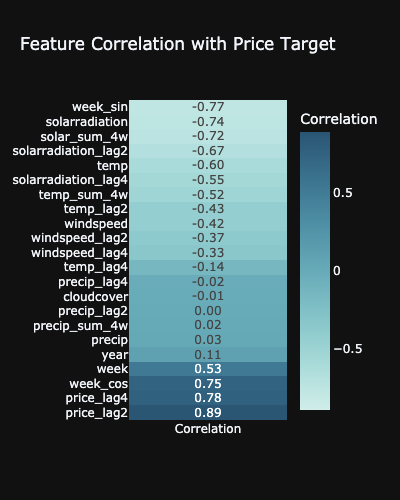

In [11]:
feature_cols = [col for col in df_features.columns if col not in ['price', 'price_min', 'price_max', 'price_target', 'date', 'start_date', 'end_date', 'category', 'unit', 'Unnamed: 0']]
fig, corr_with_target = plot_feature_target_correlation(df_features, feature_cols)
fig.show()

### Drop correlated and less impactful features

In [12]:
LOW_CORRELATION_THRESHOLD = [-0.4, 0.4]
# filter out features with low correlation
high_corr_features = corr_with_target[(corr_with_target > LOW_CORRELATION_THRESHOLD[1]) | (corr_with_target < LOW_CORRELATION_THRESHOLD[0])].index
print(high_corr_features.tolist())

['price_lag2', 'price_lag4', 'week_cos', 'week', 'windspeed', 'temp_lag2', 'temp_sum_4w', 'solarradiation_lag4', 'temp', 'solarradiation_lag2', 'solar_sum_4w', 'solarradiation', 'week_sin']


In [13]:
FEATURES_FINAL_2W_LAGS = ["price_lag2", "solarradiation_lag2", "temp_lag2"]
FEATURES_FINAL_4W_LAGS = ["price_lag4", "solarradiation_lag4", "temp_lag4"]
FEATURES_FINAL_4W_AGG = ["solar_sum_4w", "temp_sum_4w"]
FEATURES_FINAL_SEASONAL = ["week_cos", "week_sin"]

#### check for duplicates

In [14]:
df_features['date'] = pd.to_datetime(
    df_features['year'].astype(str) + '-W' +
    df_features['week'].astype(str).str.zfill(2) + '-1',
    format='%G-W%V-%u'
).dt.to_period('W').dt.to_timestamp()
num_duplicates = df_features['date'].duplicated().sum()
print("Number of duplicate dates:", num_duplicates)

if num_duplicates > 0:
    # Print the unique dates that have duplicates
    dup_dates = df_features[df_features['date'].duplicated(keep=False)]['date'].unique()
    print("Duplicate dates found:")
    print(dup_dates)
else:
    print("No duplicate dates found.")

Number of duplicate dates: 0
No duplicate dates found.


### Use the learned feature knowledge in darts modelling
Start fresh

In [15]:
data_new = data.copy()

past_covariate_cols = ["solarradiation", "windspeed", "temp", "solar_sum_4w", "temp_sum_4w"]
future_covariate_cols = ["week_cos", "week_sin"]

pp = Preprocessor(data_new)
data_new_segments = pp.split_continuous_segments()
data_new_train, data_new_test = pp.train_test_split(data_new_segments)
(training_target_series, training_past_cov_series, training_future_cov_series) = pp.build_training_series(
    data_new_train, 
    past_covariate_cols=past_covariate_cols, 
    future_covariate_cols=future_covariate_cols)
(test_target_series, test_past_cov_series, test_future_cov_series) = pp.build_test_series(data_new_test                                          , 
    past_covariate_cols=past_covariate_cols, 
    future_covariate_cols=future_covariate_cols)

Training set shape: (416, 22)
Test set shape: (105, 22)


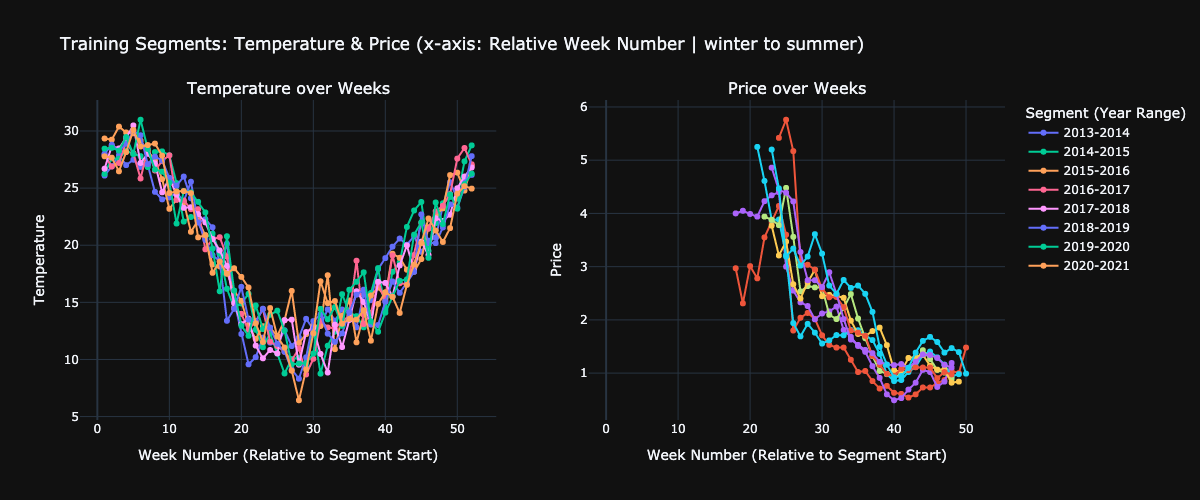

In [16]:
print("Training set shape:", data_new_train.shape)
print("Test set shape:", data_new_test.shape)


segments = []
for seg, group in data_new_train.groupby("segment"):
    group = group.sort_values("date")
    segments.append((seg, group))


fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Temperature over Weeks", "Price over Weeks"))
for seg, group in segments:
    group = group.sort_values("date")
    x_vals = np.arange(1, len(group)+1)
    start_year = group["date"].dt.year.min()
    end_year   = group["date"].dt.year.max()
    segment_label = f"{start_year}-{end_year}"  
    fig.add_trace(
        go.Scatter(
            x=x_vals,
            y=group["temp"],
            mode="lines+markers",
            name=segment_label
        ),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=x_vals,
            y=group["price"],
            mode="lines+markers",
            name=segment_label,
            showlegend=False
        ),
        row=1, col=2
    )
    
fig.update_layout(
    title_text="Training Segments: Temperature & Price (x-axis: Relative Week Number | winter to summer)",
    xaxis_title="Week Number (Relative to Segment Start)",
    xaxis2_title="Week Number (Relative to Segment Start)",
    yaxis_title="Temperature",
    yaxis2_title="Price",
    width=1200,
    height=500,
    legend_title="Segment (Year Range)"
)
fig.show()

### Baseline model - Naive seasonal

In [17]:
baseline_train, baseline_test, train_dates, test_dates = baseline_model_data(data_new_train, data_new_test)
baseline_fitted_model = fit_baseline_model(baseline_train)
naive_forecast = baseline_fitted_model.predict(len(baseline_test))
print(f"Baseline naive forecast mape: {mape(naive_forecast, baseline_test):.2f}%")

There is seasonality of order 27.
Fitting baseline model with period 27.
Baseline naive forecast mape: 33.50%


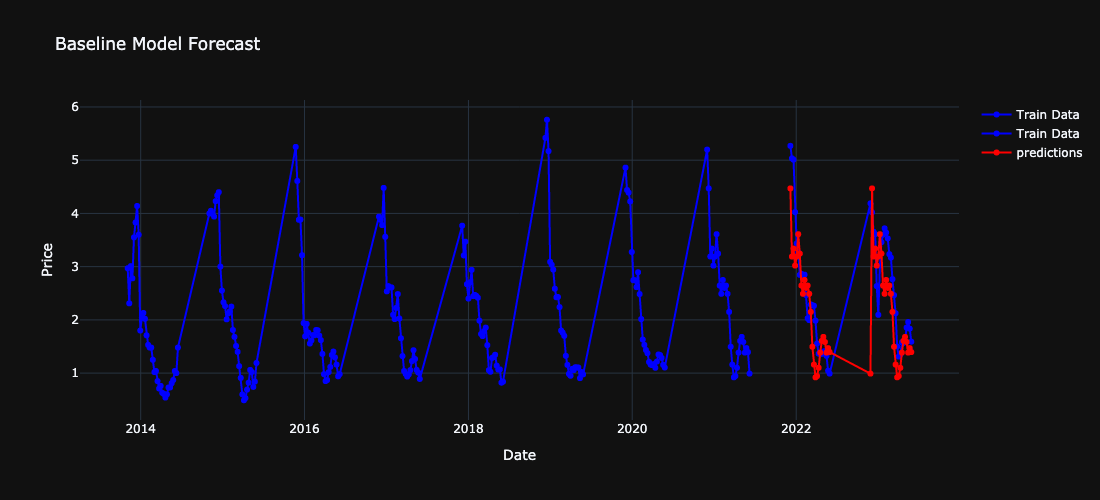

In [19]:
data_new_train_copy = data_new_train.copy().dropna()
data_new_test_copy = data_new_test.copy().dropna()
naive_forecast_df = naive_forecast.pd_dataframe()
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=data_new_train_copy["date"],
    y=data_new_train_copy["price"],
    mode='lines+markers',
    name='Train Data',
    line=dict(color='blue', width=2),
    showlegend=True
))
fig.add_trace(go.Scatter(
    x=data_new_test_copy["date"],
    y=data_new_test_copy["price"],
    mode='lines+markers',
    name='Train Data',
    line=dict(color='blue', width=2),
    showlegend=True
))
fig.add_trace(go.Scatter(
    x=test_dates,
    y=naive_forecast_df["price"],
    mode='lines+markers',
    name='predictions',
    line=dict(color='red', width=2),
    showlegend=True
))
fig.update_layout(
    title='Baseline Model Forecast',
    xaxis_title='Date',
    yaxis_title='Price',
    width=1100,
    height=500,
)
fig.show()

## Can we do better than this? 
### Lets try something simpler but where we can use the provided climate information
 - LinearRegression with lags, aggregations

### scaling features

In [20]:
scaler_target, training_target_series_scaled = pp.scale_darts_series(training_target_series, scaler=Scaler())
scaler_past, training_past_cov_series_scaled = pp.scale_darts_series(training_past_cov_series, scaler=Scaler())
scaler_future, training_future_cov_series_scaled = pp.scale_darts_series(training_future_cov_series, scaler=Scaler())
model_lags = ModelLags(
    num_lags=[-3, -2],
    num_lags_past_covariates=[-4, -3],
    num_lags_future_covariates=[0]
)

### Predict autoregressively for the next N weeks over every week in the test set

In [21]:
# model_class = make_pipeline(Ridge(alpha=1.0))
fitted_model = fit_regression_model(
    targets=training_target_series_scaled,
    past_features=training_past_cov_series_scaled,
    future_features=training_future_cov_series_scaled,
    model_lags=model_lags,
)

In [22]:
predictions = []
mape_list = []
forecast_horizon = 3
prediction_start_index = min(model_lags.num_lags)*-1 # we use lags in the target so those past n targets are needed during prediction time
test_segments = data_new_test['segment'].unique()

for test_target_seg, test_past_cov_seg, test_future_cov_seg, seg in zip(test_target_series, test_past_cov_series, test_future_cov_series, test_segments):
    ts_test_scaled = scaler_target.transform([test_target_seg])[0]
    ts_past_scaled = scaler_past.transform([test_past_cov_seg])[0]
    ts_future_scaled = scaler_future.transform([test_future_cov_seg])[0]
    
    for t in ts_test_scaled.time_index[prediction_start_index:-forecast_horizon]:
        current_series = ts_test_scaled.slice(ts_test_scaled.time_index[0], t)
        
        # Assuming a weekly frequency, forecast start is one week after t.
        forecast_start = t + pd.Timedelta(weeks=1)
        forecast_end = forecast_start + pd.Timedelta(weeks=forecast_horizon - 1)
        future_cov_slice = ts_future_scaled.slice(forecast_start, forecast_end)
        past_cov_slice = ts_past_scaled.slice(ts_past_scaled.time_index[0], forecast_end)
        
        # Forecast forecast_horizon weeks ahead
        pred = fitted_model.predict(
            n=forecast_horizon,
            series=current_series,
            past_covariates=past_cov_slice,
            future_covariates=future_cov_slice
        )
        
        actual = ts_test_scaled.slice(pred.time_index[0], pred.time_index[-1])
        mape_val = mape(actual, pred)
        mape_list.append(mape_val)

        df_pred = pred.pd_dataframe()
        df_pred["prediction_date"] = t
        df_pred["segment"] = seg
        df_pred["mape"] = mape_val
        predictions.append(df_pred)

predictions_df = pd.concat(predictions)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_

In [23]:
predictions_df.reset_index(drop=False, inplace=True)
predictions_df["date"] = pd.to_datetime(predictions_df["date"])
predictions_df = predictions_df.sort_values(["prediction_date", "date"])

inv_dfs = []
unique_pred_dates = predictions_df["prediction_date"].unique()

for pred_date in unique_pred_dates:
    df_group = predictions_df[predictions_df["prediction_date"] == pred_date].copy()
    ts_group = TimeSeries.from_dataframe(
        df_group,
        time_col="date",
        value_cols="price",
        freq=None,
        fill_missing_dates=True  # Weekly frequency
    )

    ts_group_inv = scaler_target.inverse_transform([ts_group])[0]
    
    # Extract the inverse-transformed price and add to the group DataFrame.
    df_group["price_inv"] = ts_group_inv.pd_series().values
    
    inv_dfs.append(df_group)

predictions_df_inv = pd.concat(inv_dfs, ignore_index=True)
predictions_df_inv["week"] = predictions_df_inv["date"].dt.isocalendar().week

In [24]:
data_new_test["date"] = pd.to_datetime(data_new_test["date"])
segment_start_dates = data_new_test.groupby("segment")["date"].min()

# Map the segment start over to predictions_df
predictions_df["segment_start"] = predictions_df["segment"].map(segment_start_dates)
predictions_df["week_relative"] = ((predictions_df["date"] - predictions_df["segment_start"]).dt.days // 7) + 1

actual_df = data_new_test.copy()
actual_df["segment_start"] = actual_df.groupby("segment")["date"].transform("min")
actual_df["week_relative"] = ((actual_df["date"] - actual_df["segment_start"]).dt.days // 7) + 1

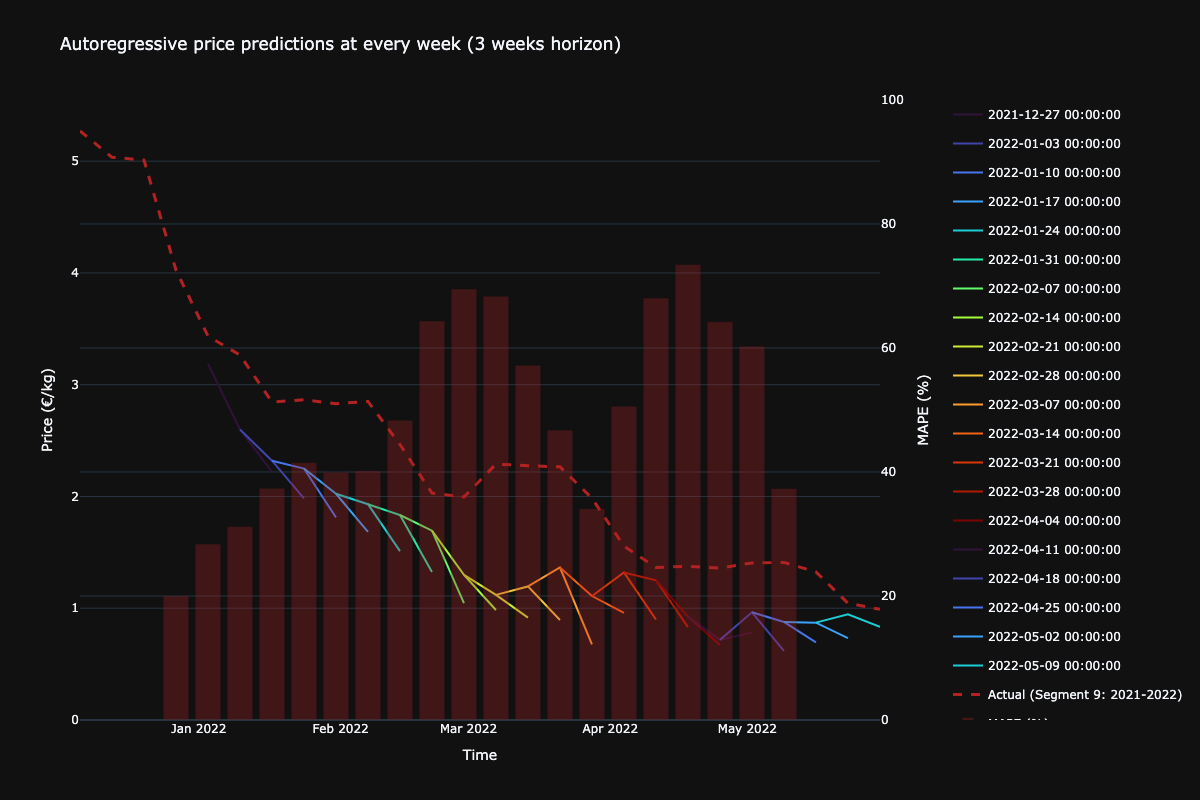

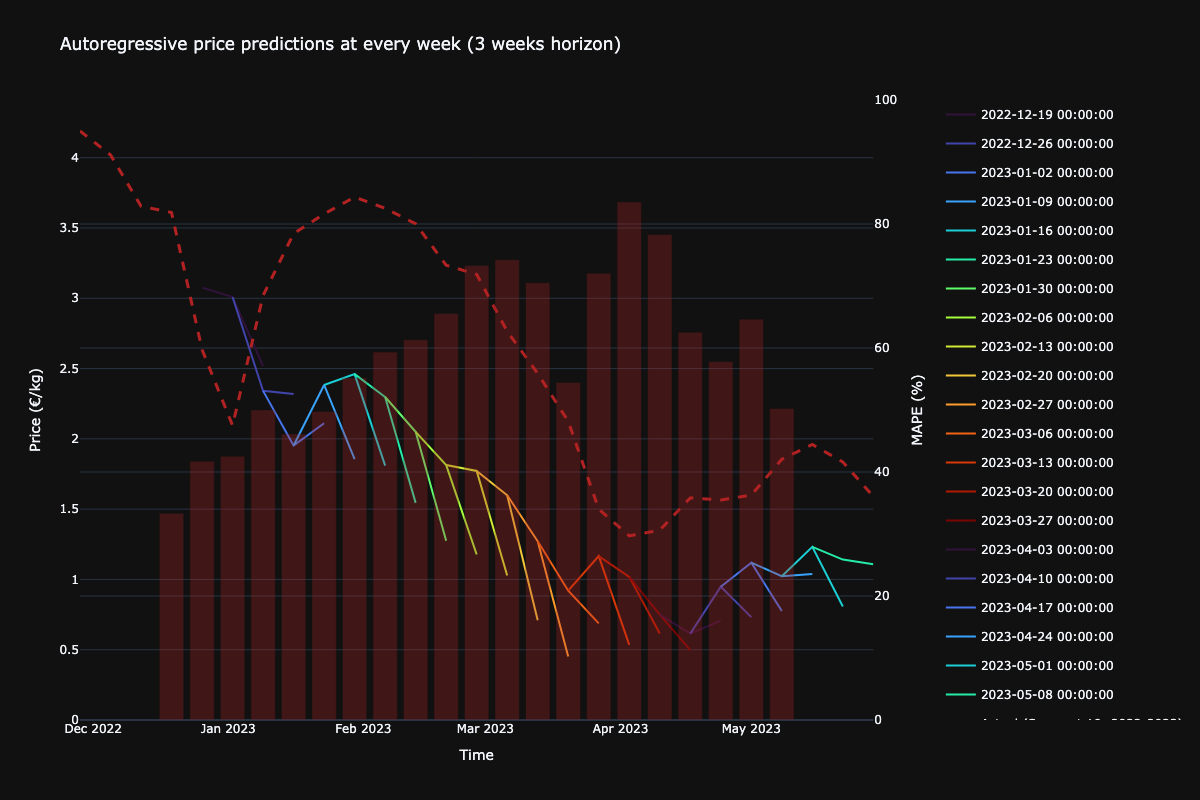

In [25]:
for seg, group in actual_df.groupby("segment"):
    seg_data = predictions_df_inv[predictions_df_inv["segment"] == seg]
    subfig = make_subplots(specs=[[{"secondary_y": True}]])
    fig = px.line(
        seg_data,
        x="date",
        y="price_inv",
        color="prediction_date",
        color_discrete_sequence=px.colors.sequential.Turbo,
    )
    fig.add_trace(
        go.Scatter(
            x=group["date"],
            y=group["price"],
            mode="lines",
            name=f"Actual (Segment {seg}: {group['segment_start'].iloc[0].year}-{group['date'].max().year})",
            line=dict(color="firebrick", width=3, dash="dash"),
            yaxis="y1",
        )
    )
    fig2 = go.Figure()
    mape_mean_per_prediction_date = seg_data.groupby("prediction_date")["mape"].mean().reset_index()
    fig2.add_trace(
        go.Bar(
            x=mape_mean_per_prediction_date["prediction_date"],
            y=mape_mean_per_prediction_date["mape"],
            name="MAPE (%)",
            marker=dict(color="firebrick"),
            opacity=0.3,
        )
    )
    fig2.update_traces(yaxis="y2")

    subfig.add_traces(fig.data + fig2.data)
    subfig.update_yaxes(rangemode="tozero")
    subfig.layout.xaxis.title = "Time"
    subfig.layout.yaxis.title = "Price (€/kg)"
    subfig.layout.yaxis2.title = "MAPE (%)"
    subfig.update_yaxes(range=[0, 100], secondary_y=True)
    # set x range to min and max of the date column where group price is not null
    group_notna = group[group["price"].notna()]
    subfig.update_xaxes(
        range=[group_notna["date"].min(), group_notna["date"].max()]
    )
    subfig.update_layout(
        width=1200,
        height=800,
        title=(
            f"Autoregressive price predictions at every week (3 weeks horizon)"
        ),
    )
    subfig.show()